# Finding the magnetic dipole position with a convolutional neural net

In [1]:
tag = 'shot_noise_1'

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pynvcenter.nv_analysis as nv_analysis


In [3]:
from sklearn.externals import joblib

In [4]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from sklearn.externals import joblib
import h5py
from keras import regularizers

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm

import h5py
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


## Problem description

we ceate images of a circle with fixed linethickness and varying position and try to get the center position of the circle by fitting to a convolutional neural net

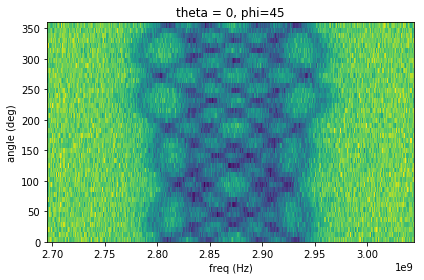

In [5]:
magnet_parameters = {
    'particle_radius':19,
    'nv_radius':73.670,
    'theta_mag': 0,
    'phi_mag': 45,
    'dipole_height':80,
    'shot_noise':1,
    'linewidth':1e7,
    'n_angle':45,
    'n_freq':351,
    'f_min':2.695e9,
    'f_max':3.045e9,
    'avrg_count_rate':1000
}







def create_image(xo, yo, plot_img=False, particle_radius=20, nv_radius=70, theta_mag=0, phi_mag=45,
                                              dipole_height=80, shot_noise=0, linewidth=1e7,
                                              n_angle=60, n_freq=300,
                                              f_min=2.65e9, f_max=3.15e9,
                                              avrg_count_rate=100):
    """
    xo, yo center of the circle
    """
    
    signal = nv_analysis.esr_2D_map_ring_scan(nv_x=xo, nv_y=yo,
                                              particle_radius=particle_radius, nv_radius=nv_radius, theta_mag=theta_mag,
                                              phi_mag=phi_mag,dipole_height=dipole_height, shot_noise=shot_noise,
                                              linewidth=linewidth,n_angle=n_angle, n_freq=n_freq,
                                              f_min=f_min, f_max=f_max,avrg_count_rate=avrg_count_rate,
                                              return_data=True, show_plot=plot_img)


        
    return signal
img = create_image(0, 5, plot_img=True, **magnet_parameters)

In [6]:
nmax = 1000000
c1 = 1000
shot_noise=300
x = np.random.poisson(lam=c1*shot_noise, size=nmax) / shot_noise
# x2 = np.random.poisson(lam=c1, size=nmax) / np.sqrt(shot_noise)
np.std(x)/c1, 1/(np.sqrt(c1)*np.sqrt(shot_noise))

(0.0018250179968047394, 0.0018257418583505537)

## create the test data

In [7]:
def generate_data(n_data, parameters=None, x_scaler=None, y_scaler=None):
    
    max_displacement = 20 ## maximum offset from the center 
    # positive and negative values
    positions = pd.DataFrame(max_displacement* (np.random.random((n_data, 2))-0.5),
                             columns = ['xo', 'yo'])
    
    positions['dipole_height'] = 20*(np.random.random((n_data)))+60
    positions['theta_mag'] = 180*(np.random.random((n_data)))
    positions['phi_mag'] = 90*(np.random.random((n_data)))

    # only positive values
#     positions = pd.DataFrame(max_displacement/2* (np.random.random((n_data, 2))), columns = ['xo', 'yo'])
        
    pbar = tqdm(total=len(positions))


    X = []
    for i, pos in positions.iterrows():
        params = parameters.copy()
        params.update(pos.to_dict())
        X.append(create_image(**params))
        pbar.update()

    pbar.close()
    X = np.array(X)
    
    
    Y = positions.values

    x_shape = X.shape

    X = X.reshape(X.shape[0], -1)


    # scale inputs and outputs
    if x_scaler is None:
        x_scaler = MinMaxScaler()
    if y_scaler is None:
        y_scaler = MinMaxScaler()

    X = x_scaler.fit_transform(X)
    Y = y_scaler.fit_transform(Y)



    # reshape to add last dimension 1 - for greyscale images
    X = X.reshape(*x_shape, 1)
    
    
    return {'X':X, 'Y': Y, 'x_scaler':x_scaler, 'y_scaler':y_scaler, 'positions' :positions }
    

In [8]:
print('genrate training set')
train_set = generate_data(10000, parameters=magnet_parameters)

x_scaler, y_scaler = train_set['x_scaler'], train_set['y_scaler']

X, Y = train_set['X'], train_set['Y']

  0%|          | 0/10000 [00:00<?, ?it/s]

genrate training set


100%|██████████| 10000/10000 [2:53:49<00:00,  1.26it/s] 


In [12]:
print('genrate validation set')
val_set = generate_data(200, x_scaler=x_scaler, y_scaler=y_scaler, parameters=magnet_parameters)


  0%|          | 0/200 [00:00<?, ?it/s]

genrate validation set


100%|██████████| 200/200 [03:09<00:00,  1.09it/s]


In [13]:
X.shape, Y.shape

((10000, 45, 351, 1), (10000, 5))

### save the data set to disk

In [14]:
print('saving the validation data (' + tag + ')')

hf = h5py.File('../data/' + tag + '_validation.h5', 'w')
hf.create_dataset("X",data=val_set['X'])
hf.create_dataset("Y",data =val_set['Y'])
hf.close()

saving the validation data (shot_noise_1)


In [15]:


print('saving the scalers data (' + tag + ')')
joblib.dump(train_set['x_scaler'], '../data/' + tag + '_x_scaler.save') 
joblib.dump(train_set['y_scaler'], '../data/' + tag + '_y_scaler.save') 


print('saving the training data (' + tag + ')')

hf = h5py.File('../data/' + tag + '_train.h5', 'w')
hf.create_dataset("X",data=train_set['X'])
hf.create_dataset("Y",data =train_set['Y'])
hf.close()

saving the scalers data (shot_noise_1)
saving the training data (shot_noise_1)


### reading the data 

In [49]:
hf = h5py.File('../data/' + tag + '_validation.h5', 'r')
val_set = {k: np.array(hf.get(k)) for k in hf.keys()}
hf.close()

In [56]:
# hf = h5py.File('../data/' + tag + '_train.h5', 'r')
# train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
# train_set['x_scaler'] = joblib.load('../data/' + tag + '_x_scaler.save') 
# train_set['y_scaler'] = joblib.load('../data/' + tag + '_y_scaler.save') 
# hf.close()

## making the model

In [17]:
# define base model
def baseline_model():
    
    #create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', input_shape=(X.shape[1],X.shape[2],X.shape[3])))

#     model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    
#     model.add(Dense(64, input_dim=64,kernel_regularizer=regularizers.l2(0.01))
    
    
    
    model.add(Flatten())
    model.add(Dense(Y.shape[1]))
#     optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.2, nesterov=True)
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model
              
              
              
              
# define base model
# def baseline_model():
    
#     #create model
#     model = Sequential()
#     #add model layers
#     model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', input_shape=(X.shape[1],X.shape[2],X.shape[3])))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# #     model.add(Dropout(0.5))
#     model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu'))
# #     model.add(Conv2D(2, kernel_size=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu'))
#     model.add(Conv2D(filters = 256, kernel_size=(3,3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
# #     
    
#     model.add(Flatten())
#     model.add(Dense(100))
#     model.add(Dropout(0.5))
#     model.add(Dense(Y.shape[1]))
# #     optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.2, nesterov=True)
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
#     return model
              


In [18]:
model = baseline_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 43, 349, 16)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 174, 16)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 58464)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 292325    
Total params: 292,485
Trainable params: 292,485
Non-trainable params: 0
_________________________________________________________________


## train the model - using my own validation API

In [19]:
# tol, max_loops = 1e-5, 100

# early_stopping = 5  # if the validation score doesn't improve for 5 iterations, then stop

# model = baseline_model()

# mse = []
# mse_val = []

# pbar = tqdm(total=max_loops)

# best_score = None
# for i in range(max_loops):

#     model.warm_start=True
#     model.fit(X[0:200],Y[0:200], epochs=1, batch_size=32,verbose=0)
#     y_pred = model.predict(X[0:200])
#     mse.append(mean_squared_error(y_pred, Y[0:200]))
    
#     y_pred = model.predict(val_set['X'])
#     mse_val.append(mean_squared_error(y_pred, val_set['Y']))
    
#     if i ==0 or mse_val[-1]<=best_score:
#         best_score = mse_val[-1]

    
#     pbar.set_description('%d: mse %0.3e, val %0.3e' %(i, mse[-1], mse_val[-1]))
#     pbar.update()
#     if mse[-1]<tol:
#         break
# pbar.close() 


In [20]:
X.shape, val_set['X'].shape

((10000, 45, 351, 1), (200, 45, 351, 1))

## train the model - using Keras API

In [21]:
model = baseline_model()

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True),
    LossHistory()
]

history = model.fit(X,Y, epochs=32, batch_size=64,verbose=1, validation_data=(val_set['X'], val_set['Y']), callbacks=callbacks)
# history = model.fit(X[0:200],Y[0:200], epochs=100, batch_size=32,verbose=1, validation_data=(val_set['X'], val_set['Y']))

Train on 10000 samples, validate on 200 samples
Epoch 1/32
10000/10000 [==============================] - 48s 5ms/step - loss: 0.2557 - mean_squared_error: 0.2557 - val_loss: 0.3139 - val_mean_squared_error: 0.3139
Epoch 2/32
10000/10000 [==============================] - 59s 6ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.2654 - val_mean_squared_error: 0.2654
Epoch 3/32
10000/10000 [==============================] - 56s 6ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.2611 - val_mean_squared_error: 0.2611
Epoch 4/32
10000/10000 [==============================] - 56s 6ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.2678 - val_mean_squared_error: 0.2678
Epoch 5/32
10000/10000 [==============================] - 54s 5ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.2477 - val_mean_squared_error: 0.2477
Epoch 6/32
10000/10000 [==============================] - 63s 6ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - 

In [22]:
history.history

{'val_loss': [0.31386221289634703,
  0.2653788197040558,
  0.2611231780052185,
  0.26784496784210204,
  0.24766042113304138,
  0.2569285321235657,
  0.24417241871356965,
  0.28481060266494751,
  0.27728396058082583],
 'val_mean_squared_error': [0.31386221289634703,
  0.2653788197040558,
  0.2611231780052185,
  0.26784496784210204,
  0.24766042113304138,
  0.2569285321235657,
  0.24417241871356965,
  0.28481060266494751,
  0.27728396058082583],
 'loss': [0.25574528384208678,
  0.014568048894405366,
  0.0099879078820347793,
  0.0076774750769138334,
  0.0060382107168436049,
  0.0055353632844984532,
  0.0045446337930858133,
  0.0040985855005681512,
  0.003484472194314003],
 'mean_squared_error': [0.25574528384208678,
  0.014568048894405366,
  0.0099879078820347793,
  0.0076774750769138334,
  0.0060382107168436049,
  0.0055353632844984532,
  0.0045446337930858133,
  0.0040985855005681512,
  0.003484472194314003]}

Text(0,0.5,'mean squared error')

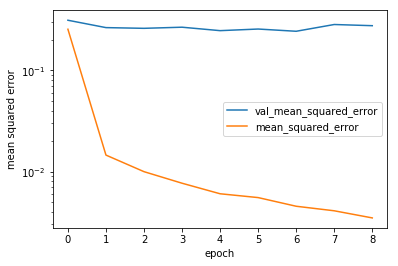

In [23]:
for value in ['val_mean_squared_error', 'mean_squared_error']:
    plt.semilogy(history.history[value],label = value)
    
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean squared error')

In [24]:
val_set['X'].min(),val_set['X'].max()

(0.0, 1.0000000000000036)

### save the model

In [25]:
model.save('../models/'+tag+'_model.h5')
print('../models/'+tag+'_model.h5 saved')

../models/shot_noise_1_model.h5 saved


## learning curve
we use the keras wrapper for sklearn to be able to use the sklearn function

In [174]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold

In [175]:
from sklearn.model_selection import ShuffleSplit

In [256]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.loglog(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.loglog(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt, {'train_scores_mean':train_scores_mean,
                 'train_scores_std':train_scores_std,
                 'test_scores_mean':test_scores_mean,
                'test_scores_std':test_scores_std}






In [271]:
train_sizes= [int(x) for x in 2**np.arange(2,15)]
train_sizes

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

In [272]:
# create model
model = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=16, verbose=0)
# evaluate using 10-fold cross validation
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = cross_val_score(model, X[0:100], Y[0:100], cv=kfold)
# print(results.mean())

[learning_curve] Training set sizes: [    4     8    16    32    64   128   256   512  1024  2048  4096  8192
 16384]
[CV]  ................................................................
[CV] ................................................. , total=  55.8s
[CV]  ................................................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:   55.9s remaining:    0.0s


[CV] ................................................. , total=  44.3s
[CV]  ................................................................
[CV] ................................................. , total=  48.1s
[CV]  ................................................................
[CV] ................................................. , total=  47.7s
[CV]  ................................................................
[CV] ................................................. , total=  50.8s
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.7min
[CV]  ................................................................
[CV] ................................................. , total= 2.8min
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=None)]: Done  39 out of  39 | elapsed: 515.1min finished


CPU times: user 20h 50min 48s, sys: 55min 1s, total: 21h 45min 49s
Wall time: 8h 35min 8s


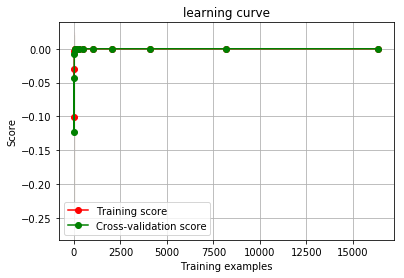

In [273]:
%%time

cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
# train_sizes=np.linspace(.1, 1.0, 10)
# train_sizes, train_scores, test_scores = learning_curve(
#         model, X[0:100], Y[0:100], cv=cv,
# #     n_jobs=n_jobs,
#     train_sizes=train_sizes,
#     verbose=2)

# n_max = 10000

plt, data_learn = plot_learning_curve(model, 'learning curve', X, Y, cv=cv, train_sizes=train_sizes)

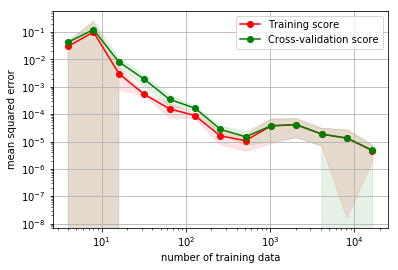

In [287]:
# plt.loglog(train_sizes, -data_learn['train_scores_mean'])
# plt.loglog(train_sizes, -data_learn['test_scores_mean'])

train_scores_mean = -data_learn['train_scores_mean']
train_scores_std = data_learn['train_scores_std']
test_scores_mean = -data_learn['test_scores_mean']
test_scores_std = data_learn['test_scores_std']

fig = plt.figure()
plt.grid()

plt.loglog(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.loglog(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")


plt.legend(loc="best")
plt.xlabel('number of training data')
plt.ylabel('mean squared error')

fig.savefig('../images/'+tag+'_learning_curve.jpg')

In [286]:
train_scores_mean - train_scores_std

array([  1.44900320e-02,  -2.43791354e-02,   7.89975934e-04,
         4.83454593e-04,   7.21546519e-05,   7.07786603e-05,
         7.67531052e-06,   4.42389208e-06,   8.24911536e-06,
         1.36664203e-05,   6.90914926e-06,   1.58184597e-08,
         1.85281004e-06])

[learning_curve] Training set sizes: [   4    8   16   32   64  128  256  512 1024 2048]
[CV]  ................................................................
[CV] ................................................. , total=  36.2s
[CV]  ................................................................


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:   36.4s remaining:    0.0s


[CV] ................................................. , total=  35.2s
[CV]  ................................................................
[CV] ................................................. , total=  40.3s
[CV]  ................................................................
[CV] ................................................. , total=  45.2s
[CV]  ................................................................
[CV] ................................................. , total=  55.8s
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.8min
[CV]  ................................................................
[CV] ................................................. , total= 3.0min
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=None)]: Done  30 out of  30 | elapsed: 75.1min finished


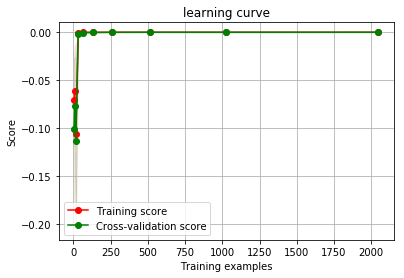

In [254]:
%%time

cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
# train_sizes=np.linspace(.1, 1.0, 10)
# train_sizes, train_scores, test_scores = learning_curve(
#         model, X[0:100], Y[0:100], cv=cv,
# #     n_jobs=n_jobs,
#     train_sizes=train_sizes,
#     verbose=2)

# n_max = 10000

plot_learning_curve(model, 'learning curve', X, Y, cv=cv, train_sizes=train_sizes)

In [206]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
train_sizes=np.linspace(.1, 1.0, 10)
n_jobs=4
train_sizes, train_scores, test_scores = learning_curve(
        model, X[0:100], Y[0:100], cv=cv,
#     n_jobs=n_jobs,
    train_sizes=train_sizes,
    verbose=2)

[learning_curve] Training set sizes: [ 8 16 24 32 40 48 56 64 72 80]
[CV]  ................................................................
[CV] ................................................. , total=   5.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] ................................................. , total=   6.8s
[CV]  ................................................................
[CV] ................................................. , total=   8.9s
[CV]  ................................................................
[CV] ................................................. , total=  11.2s
[CV]  ................................................................
[CV] ................................................. , total=  13.0s
[CV]  ................................................................
[CV] ................................................. , total=  14.8s
[CV]  ................................................................
[CV] ................................................. , total=  16.7s
[CV]  ................................................................
[CV] ................................................. , total=  18.6s
[CV]  ................................................................
[CV] .

[CV] ................................................. , total=  25.9s
[CV]  ................................................................
[CV] ................................................. , total=   7.2s
[CV]  ................................................................
[CV] ................................................. , total=   9.1s
[CV]  ................................................................
[CV] ................................................. , total=  11.4s
[CV]  ................................................................
[CV] ................................................. , total=  13.6s
[CV]  ................................................................
[CV] ................................................. , total=  15.7s
[CV]  ................................................................
[CV] ................................................. , total=  17.5s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 27.0min finished


## show how well the model fits
### on the training data

In [26]:
n_max = 100

In [27]:
Y_predict = model.predict(X[0:n_max])

#### scaled outputs

Text(0,0.5,'yo')

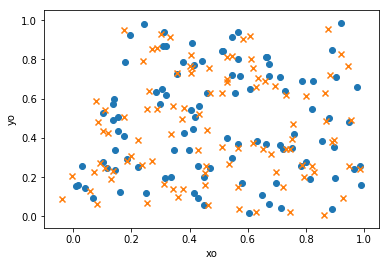

In [28]:
plt.scatter(Y[:n_max, 0], Y[:n_max, 1], marker='o')
plt.scatter(Y_predict[:n_max, 0], Y_predict[:n_max, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

In [30]:
Y.shape

(10000, 5)

Text(0,0.5,'yo')

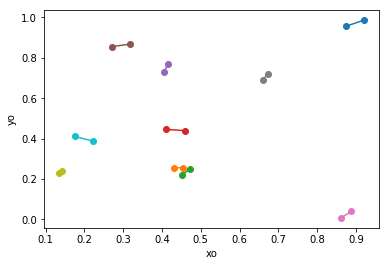

In [31]:
for i in range(10):

    plt.plot([Y[i, 0], Y_predict[i, 0]], [Y[i, 1], Y_predict[i, 1]], 'o-')
plt.xlabel('xo')
plt.ylabel('yo')

#### original outputs

Text(0,0.5,'yo')

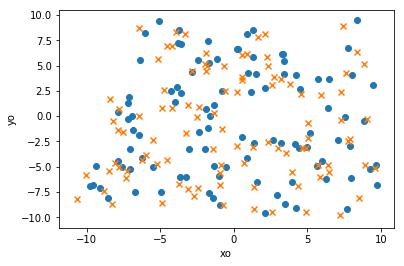

In [32]:
Y_real = y_scaler.inverse_transform(Y[0:n_max])
Y_pred_real = y_scaler.inverse_transform(Y_predict[0:n_max])

plt.scatter(Y_real[0:n_max, 0], Y_real[0:n_max, 1], marker='o')
plt.scatter(Y_pred_real[:, 0], Y_pred_real[:, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

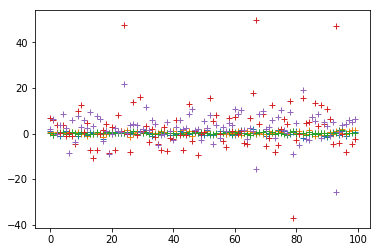

In [33]:
plt.plot(Y_real-Y_pred_real, '+')

In [34]:
Y_pred_real[0]

array([  7.44395256,   8.88342476,  72.63204193,  80.96573639,  14.80110264], dtype=float32)

{'xo': 6.8713422,
 'yo': -2.6784987,
 'dipole_height': 65.128639,
 'theta_mag': 131.86258}

In [49]:
magnet_parameters

{'particle_radius': 20,
 'nv_radius': 70,
 'theta_mag': 0,
 'phi_mag': 45,
 'dipole_height': 80,
 'shot_noise': 1,
 'linewidth': 10000000.0,
 'n_angle': 45,
 'n_freq': 351,
 'f_min': 2695000000.0,
 'f_max': 3045000000.0,
 'avrg_count_rate': 1000}

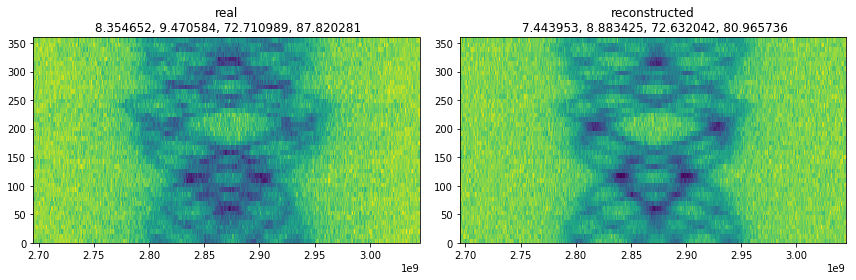

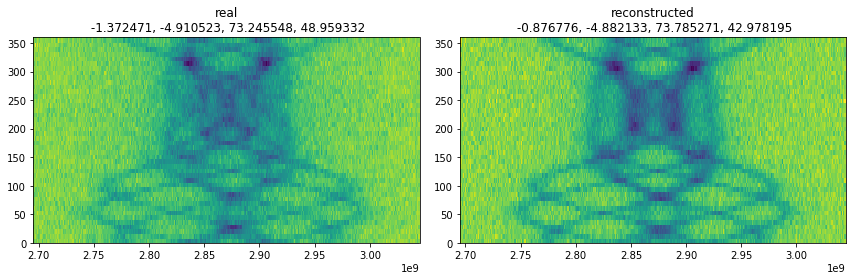

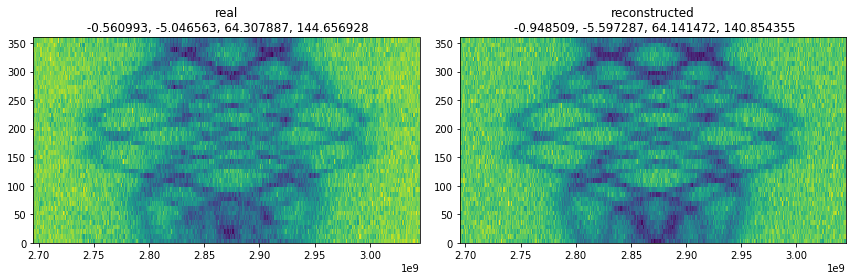

In [35]:

n_plot = 3

f_min=magnet_parameters['f_min']
f_max=magnet_parameters['f_max']
n_angle=magnet_parameters['n_angle']
n_freq=magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)

x_shape = X[0:n_plot, :,:,0].shape
X_real = x_scaler.inverse_transform(X[0:n_plot].reshape(x_shape[0], -1)).reshape(x_shape)

for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (12,4))
    

    ax[0].pcolor(frequencies, angle, X_real[i])
    ax[0].set_title('real\n {:f}, {:f}, {:f}, {:f}'.format(*Y_real[i]))
    # get the parameters (default + the predicted)
    param = magnet_parameters.copy()
    param.update({k:v for k, v in zip(train_set['positions'].keys(), Y_pred_real[i])})
#     plot_img=False
    # and create the image
    img = create_image(**param)
    ax[1].pcolor(frequencies, angle, img)
    ax[1].set_title('reconstructed\n {:f}, {:f}, {:f}, {:f}'.format(*Y_pred_real[i]))
    plt.tight_layout()
    

### on the validation data

In [36]:
Y_predict = model.predict(val_set['X'][0:n_max])

#### scaled outputs

Text(0,0.5,'yo')

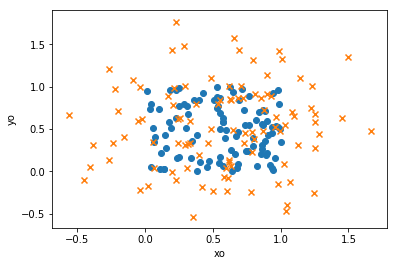

In [37]:
plt.scatter(val_set['Y'][:n_max, 0], val_set['Y'][:n_max, 1], marker='o')
plt.scatter(Y_predict[:n_max, 0], Y_predict[:n_max, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

Text(0,0.5,'yo')

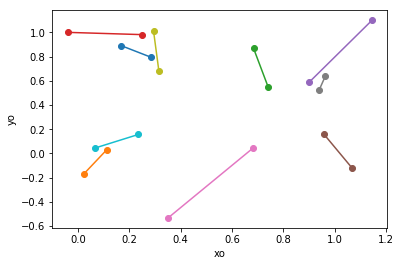

In [38]:
for i in range(10):

    plt.plot([val_set['Y'][i, 0], Y_predict[i, 0]], [val_set['Y'][i, 1], Y_predict[i, 1]], 'o-')
plt.xlabel('xo')
plt.ylabel('yo')

#### original outputs

Text(0,0.5,'yo')

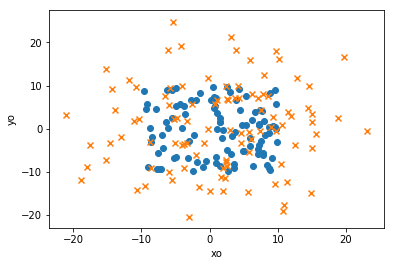

In [39]:
Y_real = y_scaler.inverse_transform(val_set['Y'][0:n_max])
Y_pred_real = y_scaler.inverse_transform(Y_predict[0:n_max])

plt.scatter(Y_real[0:n_max, 0], Y_real[0:n_max, 1], marker='o')
plt.scatter(Y_pred_real[:, 0], Y_pred_real[:, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

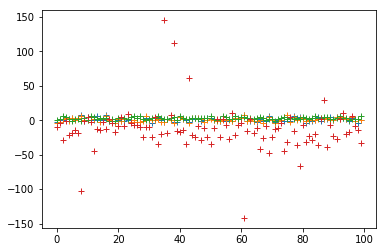

In [61]:
plt.plot(Y_real-Y_pred_real, '+')

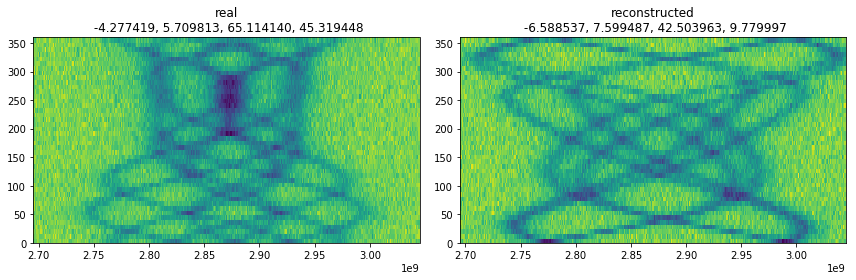

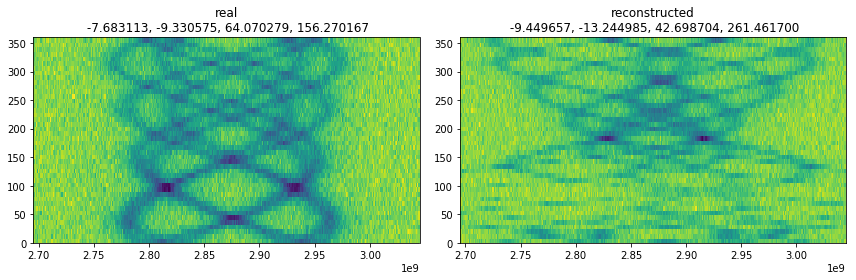

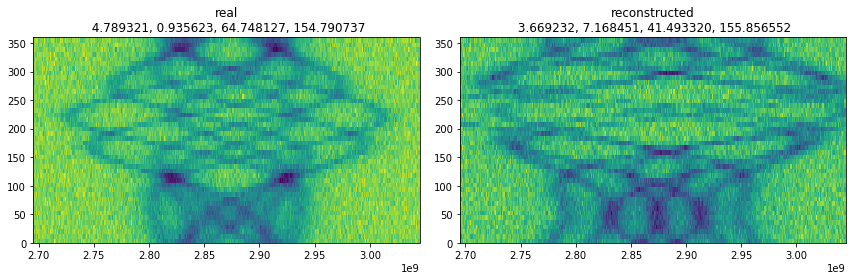

In [40]:

n_plot = 3

f_min=magnet_parameters['f_min']
f_max=magnet_parameters['f_max']
n_angle=magnet_parameters['n_angle']
n_freq=magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)

x_shape = val_set['X'][0:n_plot, :,:,0].shape
X_real = x_scaler.inverse_transform(val_set['X'][0:n_plot].reshape(x_shape[0], -1)).reshape(x_shape)

for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (12,4))
    

    ax[0].pcolor(frequencies, angle, X_real[i])
    ax[0].set_title('real\n {:f}, {:f}, {:f}, {:f}'.format(*Y_real[i]))
    # get the parameters (default + the predicted)
    param = magnet_parameters.copy()
    param.update({k:v for k, v in zip(train_set['positions'].keys(), Y_pred_real[i])})
#     plot_img=False
    # and create the image
    img = create_image(**param)
    ax[1].pcolor(frequencies, angle, img)
    ax[1].set_title('reconstructed\n {:f}, {:f}, {:f}, {:f}'.format(*Y_pred_real[i]))
    plt.tight_layout()
    

## show learning progress

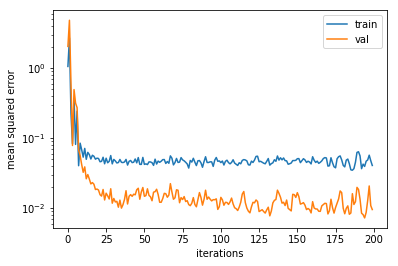

In [67]:
plt.semilogy(mse, label ='train')
plt.semilogy(mse_val, label = 'val')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.legend()

## continue to train the model many times in a loop

In [24]:
print('generating data')
train_set = generate_data(100, max_displacement=max_displacement, x_scaler=x_scaler, y_scaler=y_scaler)
X =train_set['X']
Y =train_set['Y']

pbar = tqdm(total=max_loops)

model.warm_start=True
print('fitting model')
for i in range(max_loops):

    model.fit(X,Y, epochs=2, batch_size=32,verbose=0)
    y_pred = model.predict(X)
    mse.append(mean_squared_error(y_pred, Y))
    
    y_pred = model.predict(val_set['X'])
    mse_val.append(mean_squared_error(y_pred, val_set['Y']))
    pbar.set_description('%d: mse %0.3e, val %0.3e' %(i, mse[-1], mse_val[-1]))
    pbar.update()
    if mse[-1]<tol:
        break
pbar.close() 

  0%|          | 0/100 [00:00<?, ?it/s]

73: mse 9.835e-06, val 1.095e-01:  37%|███▋      | 74/200 [02:04<03:29,  1.66s/it]


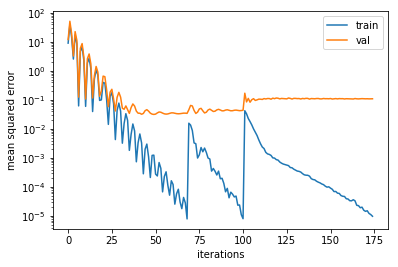

In [25]:
plt.semilogy(mse, label ='train')
plt.semilogy(mse_val, label = 'val')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.legend()

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 58, 298, 16)       160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 148, 16)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 66304)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 132610    
Total params: 132,770
Trainable params: 132,770
Non-trainable params: 0
_________________________________________________________________


In [29]:
np.product(X.shape)

1800000

## how well does the model generalize?

In [141]:
val_set = generate_data(100, max_displacement=20, x_scaler=x_scaler, y_scaler=y_scaler)

100%|██████████| 100/100 [01:39<00:00,  1.00s/it]


In [28]:
np.min(val_set['X']), np.max(val_set['X'])

(0.0, 1.0000000000000071)

In [29]:
Y_val_predict = model.predict(val_set['X'])

In [30]:
Y_val_predict

array([[ 0.81033361,  0.24699694],
       [ 0.31534111,  0.59965205],
       [ 0.77695608,  0.30731371],
       [ 0.64716595,  0.67310709],
       [ 0.55462402,  0.73723656]], dtype=float32)

In [31]:
val_set['Y']

array([[ 0.79157482,  0.07892947],
       [ 0.        ,  0.65634529],
       [ 0.57930526,  0.        ],
       [ 1.        ,  0.98801825],
       [ 0.57757584,  1.        ]])

In [32]:
mean_squared_error(Y_val_predict, val_set['Y'])

0.055799258731395546

In [40]:
model.save('../data/model.HDF5')

In [37]:
!ls ../

data       notebooks  pynvcenter


# Evaluating the performance
## tansfer learning
we train on models without noise and then try to estimate the parameters on a noisy dataset

In [315]:
from keras.models import load_model

tag = 'no_noise'
model2 = load_model('../models/'+tag+'_model.h5')

In [320]:
magnet_parameters = {'particle_radius': 20,
 'nv_radius': 70,
 'theta_mag': 0,
 'phi_mag': 45,
 'dipole_height': 80,
 'shot_noise': 4,
 'linewidth': 10000000.0,
 'n_angle': 60,
 'n_freq': 300,
 'f_min': 2650000000.0,
 'f_max': 3150000000.0,
 'avrg_count_rate': 100}

In [322]:
n_max=10

val_set_noise = generate_data(n_max, max_displacement=max_displacement, x_scaler=x_scaler, y_scaler=y_scaler, parameters=magnet_parameters)

100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


### on the validation data

In [340]:
Y_predict = model2.predict(val_set_noise['X'][0:n_max])

In [341]:
val_set_noise['Y'][0:n_max]

array([[ 0.71279018,  0.5037053 ],
       [ 0.        ,  0.36894522],
       [ 0.96733234,  0.        ],
       [ 0.62006189,  1.        ],
       [ 0.33384992,  0.54634666],
       [ 0.34743574,  0.1295943 ],
       [ 0.73131249,  0.43486744],
       [ 0.92437398,  0.2135967 ],
       [ 1.        ,  0.47866118],
       [ 0.69517502,  0.05433951]])

In [342]:
Y_predict

array([[ 0.10159893, -0.31057537],
       [-0.4438259 , -0.57897997],
       [ 0.41985765, -0.47655505],
       [-0.05557998,  0.05078126],
       [-0.21361956, -0.40721184],
       [-0.1180307 , -0.74581516],
       [ 0.25952157, -0.49288934],
       [ 0.40617061, -0.51206672],
       [ 0.43219557, -0.4210974 ],
       [ 0.23868801, -0.48701462]], dtype=float32)

#### scaled outputs

Text(0,0.5,'yo')

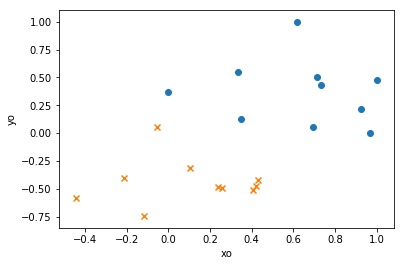

In [343]:
plt.scatter(val_set_noise['Y'][:n_max, 0], val_set_noise['Y'][:n_max, 1], marker='o')
plt.scatter(Y_predict[:n_max, 0], Y_predict[:n_max, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

Text(0,0.5,'yo')

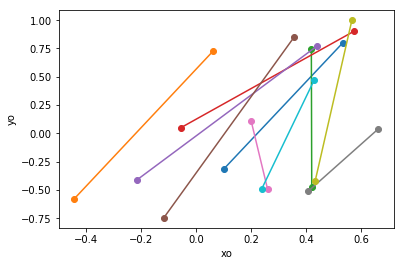

In [344]:
for i in range(10):

    plt.plot([val_set['Y'][i, 0], Y_predict[i, 0]], [val_set['Y'][i, 1], Y_predict[i, 1]], 'o-')
plt.xlabel('xo')
plt.ylabel('yo')

#### original outputs

Text(0,0.5,'yo')

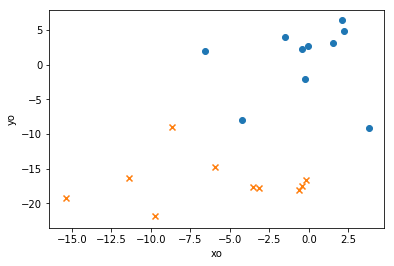

In [345]:
Y_real = y_scaler.inverse_transform(val_set['Y'][0:n_max])
Y_pred_real = y_scaler.inverse_transform(Y_predict[0:n_max])

plt.scatter(Y_real[0:n_max, 0], Y_real[0:n_max, 1], marker='o')
plt.scatter(Y_pred_real[:, 0], Y_pred_real[:, 1], marker='x')
plt.xlabel('xo')
plt.ylabel('yo')

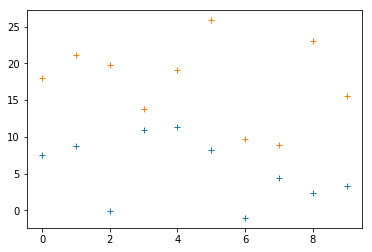

In [338]:
plt.plot(Y_real-Y_pred_real, '+')

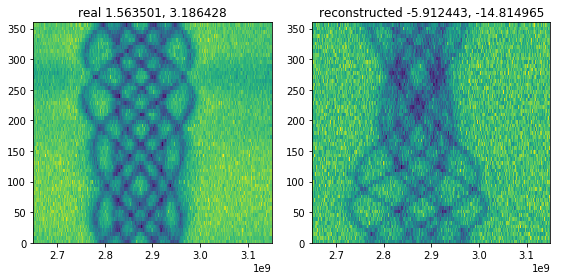

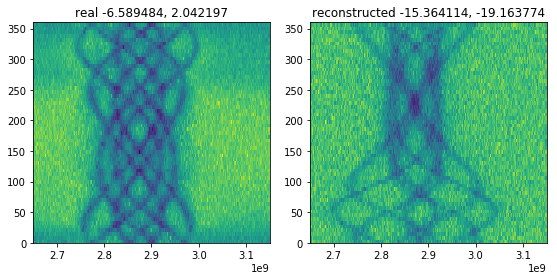

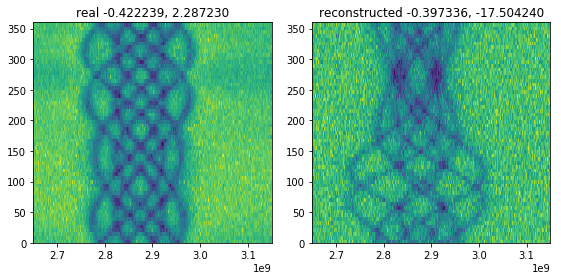

In [339]:

n_plot = 3

f_min=2.65e9
f_max=3.15e9
n_angle=60
n_freq=300
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)


x_shape = val_set['X'][0:n_plot, :,:,0].shape
X_real = x_scaler.inverse_transform(val_set['X'][0:n_plot].reshape(x_shape[0], -1)).reshape(x_shape)

for i in range(n_plot):
    fig, ax  = plt.subplots(1, 2, figsize = (8, 4))
    

    ax[0].pcolor(frequencies, angle, X_real[i])
    ax[0].set_title('real {:f}, {:f}'.format(*Y_real[i]))
    
    img = create_image(*Y_pred_real[i], plot_img=False, **magnet_parameters)
    ax[1].pcolor(frequencies, angle, img)
    ax[1].set_title('reconstructed {:f}, {:f}'.format(*Y_pred_real[i]))
    plt.tight_layout()
    